# Specie distribution

In [1]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 
training = 'east-asia' # 'australia'
interest = 'south-east-asia'
savefig = False

###########################################################

In [2]:
import os

# import numpy as np
import pandas as pd 
import geopandas as gpd
import elapid as ela

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

import warnings
warnings.filterwarnings("ignore")

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
figsize = (18,12)
projection = ccrs.PlateCarree()

def make_map(figsize, projection, res):

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)

    ax.add_feature(cfeature.BORDERS.with_scale(res)) # , color='gray'
    ax.add_feature(cfeature.STATES.with_scale(res),
                   linestyle=':', edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale(res), color='lightgray')
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    
    gl = ax.gridlines(color='grey', linestyle=':', draw_labels=True, rotate_labels=False) #ylocs=[-45, -60, -75])
    
    return fig, ax, gl

## 1. Species Occurrence

In [4]:
# data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data') 
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
figs_path = os.path.join(os.path.dirname(os.getcwd()), 'figs')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input')
for path in [figs_path, os.path.join(input_path, 'train'), os.path.join(input_path, 'test')]:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
regions = {
    'east-asia': ['China', 'Taiwan', 'Japan', 'North Korea', 'South Korea'],
    'south-east-asia': ['Brunei', 'Myanmar', 'Cambodia', 'East Timor', 'Indonesia', 'Laos', 'Malaysia', 'Philippines', 'Singapore', 'Thailand', 'Vietnam'],
    'melanesia': ['Fiji', 'Vanuatu', 'Solomon Islands', 'Papua New Guinea'],
    'australia': ['Australia'],
    'australasia' : ['Australia', 'New Zealand'],
}

In [6]:
occurences_global = pd.read_csv(os.path.join(data_path, 'species', specie, '%s_aggregated.csv' %specie))
print('Number of occurences globally is: %s' %len(occurences_global))

Number of occurences globally is: 1389


In [7]:
# make geopandas dataframe
geometry = gpd.points_from_xy(occurences_global['lon'], occurences_global['lat'])
occurences = gpd.GeoDataFrame(occurences_global['source'], geometry=geometry)

# drop occurences without coordinates
occurences = occurences[~occurences.is_empty]
print('Number of occurences globally after removing occurrences without coordinates: %s' %len(occurences))

Number of occurences globally after removing occurrences without coordinates: 411


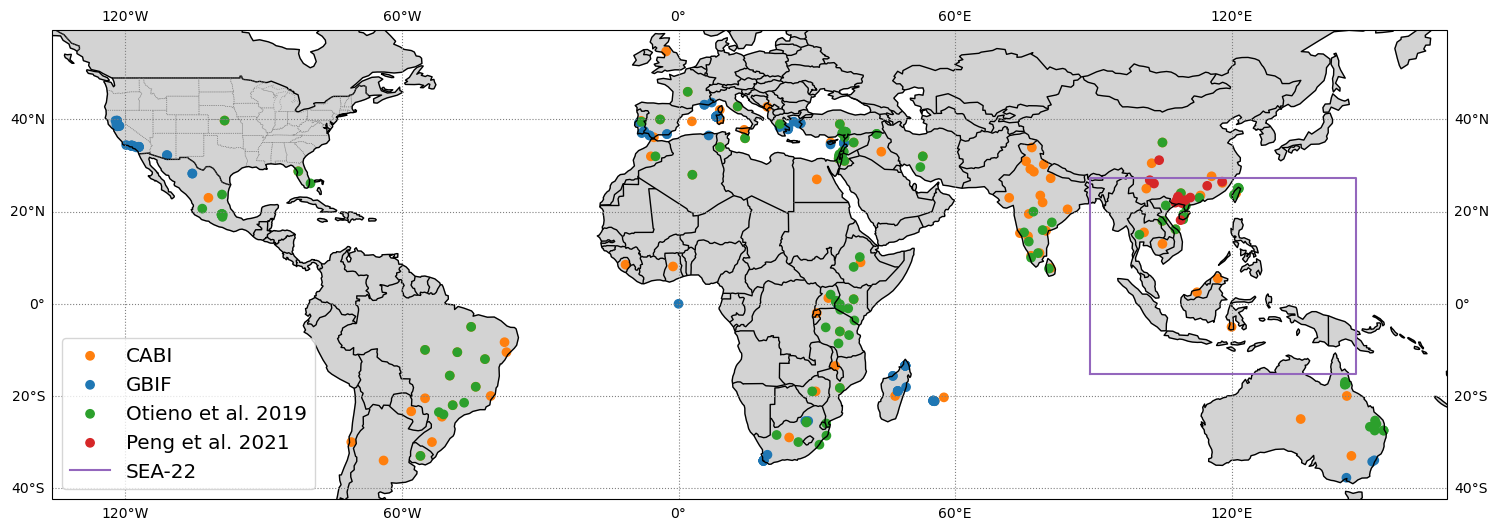

In [8]:
colors = list(mcolors.TABLEAU_COLORS.keys())
dict_color = {src: colors[i]  for i, src in enumerate(occurences.source.unique())}
occurences['color'] = occurences['source'].map(dict_color)

fig, ax, gl = make_map(figsize, projection, res='110m')

for src, df in occurences.groupby('source'):
    ax.scatter(x=df.geometry.x, y=df.geometry.y, color=df.color, label=src, transform=ccrs.PlateCarree())

ax.plot([89.26, 146.96, 146.96, 89.26, 89.26], [-15.14, -15.14, 27.26, 27.26, -15.14], transform=ccrs.PlateCarree(), label='SEA-22', color=colors[len(occurences.source.unique())])   
ax.legend(loc='lower left')

In [9]:
if savefig:
    fig.savefig(os.path.join(figs_path, '01_presence_%s_global.png' %specie), transparent=True)

## 2. Define Training Area

In [10]:
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
countries = gpd.read_file(shpfilename)

In [11]:
# select and combine countries in one dataframe
gdf_countries = gpd.GeoDataFrame()
for country in regions[training]:
    cntry = countries.loc[countries['ADMIN'] == country]
    gdf_countries = pd.concat([gdf_countries, cntry])

# write basemap to shape file
gdf_countries.to_file(os.path.join(input_path, 'train', '%s.shp' %training))

gdf_countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
195,Admin-0 country,3,2,China,CH1,1,2,Country,1,China,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((118.18301 24.49629, 118.14951 ..."
45,Admin-0 country,1,3,Taiwan,TWN,0,2,Sovereign country,1,Taiwan,...,NaN,Admin-1 states provinces,NaN,NaN,NaN,NaN,NaN,Admin-1 states provinces,NaN,"MULTIPOLYGON (((121.00879 22.62036, 120.94688 ..."
135,Admin-0 country,3,2,Japan,JPN,0,2,Sovereign country,1,Japan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((133.37051 36.20386, 133.32471 ..."
89,Admin-0 country,1,3,North Korea,PRK,0,2,Sovereign country,1,North Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((128.37461 38.62344, 128.33945 ..."
55,Admin-0 country,1,2,South Korea,KOR,0,2,Sovereign country,1,South Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((126.63389 37.78184, 126.66455 ..."


In [12]:
in_region = occurences.within(gdf_countries.geometry.values[0])
for i in range(1, len(gdf_countries)):
    in_region = in_region | occurences.within(gdf_countries.geometry.values[i])
occurences_region = occurences[in_region]
print('Number of occurences in %s is: %s' %(training, len(occurences_region)))

Number of occurences in east-asia is: 36


In [13]:
occurences_region['lon'] = occurences_region['geometry'].x
occurences_region['lat'] = occurences_region['geometry'].y
occurences_region.to_csv(os.path.join(input_path, 'train', '%s_presence_%s.csv' %(specie, training)), columns=['lon', 'lat'], index=False)

load host data (Eucalyptus) from Abbasi et al. 2023
https://www.nature.com/articles/s41597-023-02383-w

In [14]:
if training == 'east-asia':
    planted_forest_file = os.path.join('zip://', data_path, 'planted-forest-east-asia', 'planted-forest-east-asia.zip')
    eucalyptus_forest = gpd.read_file(planted_forest_file, where="Genus='Eucalyptus'")

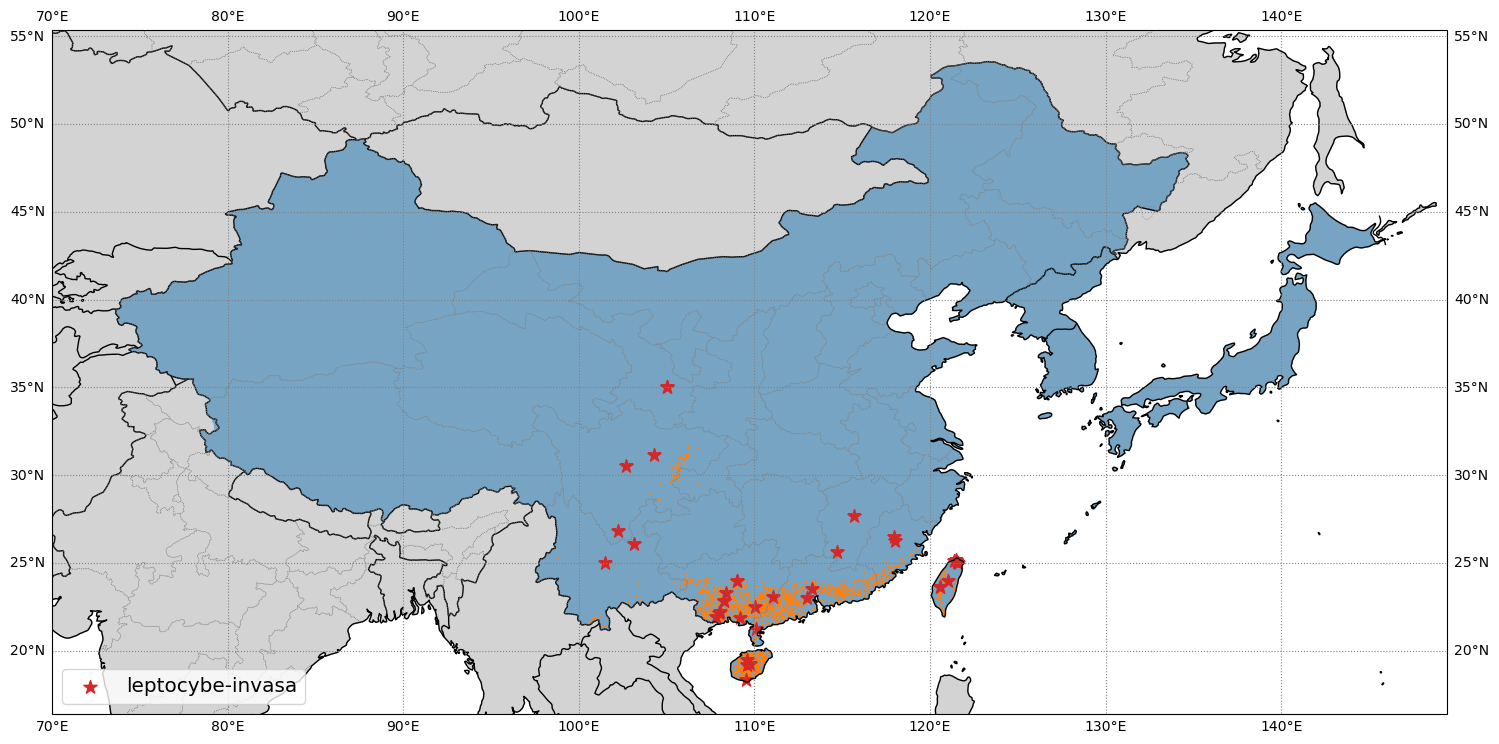

In [15]:
fig, ax, gl = make_map(figsize, projection, res='50m')

gdf_countries.plot(ax=ax, alpha=0.5)
if training == 'east-asia':
    eucalyptus_forest.plot(ax=ax, color='tab:orange', label='Planted Eucalyptus')
occurences_region.plot(ax=ax, marker='*', markersize=100, color='tab:red', label=specie)

if training == 'australasia':
    xlim = [110, gdf_countries.geometry.bounds.maxx.max()]
    ylim = [gdf_countries.geometry.bounds.miny.min(), gdf_countries.geometry.bounds.maxy.max()]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    gl = ax.gridlines(color='grey', linestyle=':', draw_labels=True, rotate_labels=False) #ylocs=[-45, -60, -75])

ax.legend(loc='lower left')

In [16]:
if savefig:
    fig.savefig(os.path.join(figs_path, '01_presence_%s_%s.png' %(specie, training)), transparent=True)

## 3. Define Area of Interest

In [17]:
# select and combine countries in one dataframe
gdf_countries_interest = gpd.GeoDataFrame()
for country in regions[interest]:
    cntry = countries.loc[countries['ADMIN'] == country]
    gdf_countries_interest = pd.concat([gdf_countries_interest, cntry])
gdf_countries_interest.to_file(os.path.join(input_path, 'test', '%s.shp' %interest))

In [18]:
in_interest = occurences.within(gdf_countries_interest.geometry.values[0])
for i in range(1, len(gdf_countries_interest)):
    in_interest = in_interest | occurences.within(gdf_countries_interest.geometry.values[i])
occurences_interest = occurences[in_interest]
# occurences_interest.remove_repeated_points()
print('Number of occurences in %s is: %s' %(interest, len(occurences_interest)))

Number of occurences in south-east-asia is: 11


In [19]:
occurences_interest['lon'] = occurences_interest['geometry'].x
occurences_interest['lat'] = occurences_interest['geometry'].y
occurences_interest.to_csv(os.path.join(input_path, 'test', '%s_presence_%s.csv' %(specie, interest)), columns=['lon', 'lat'], index=False)

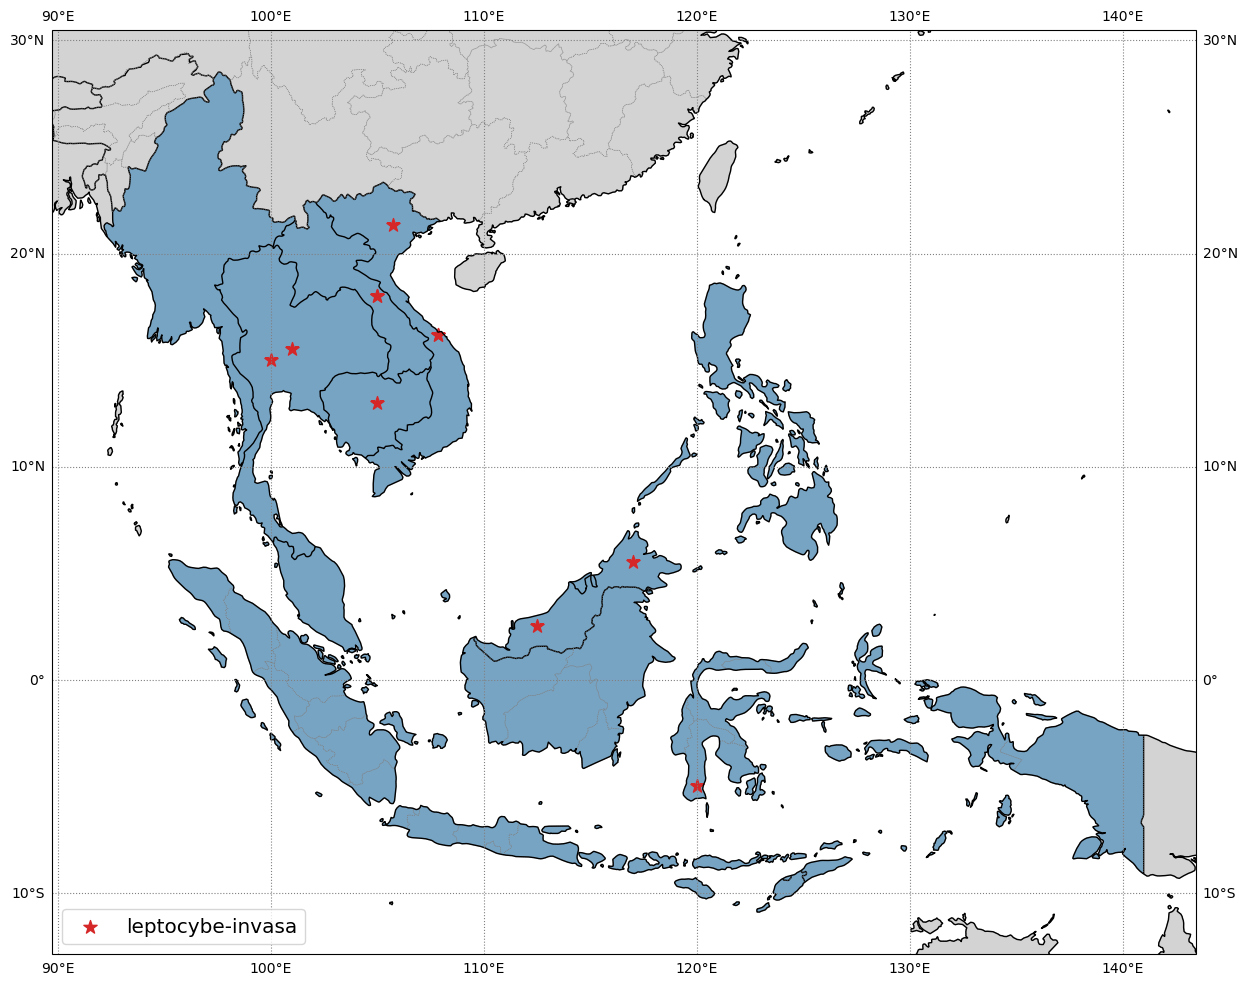

In [20]:
fig, ax, gl = make_map(figsize, projection, res='50m')

gdf_countries_interest.plot(ax=ax, alpha=0.5)
occurences_interest.plot(ax=ax, marker='*', markersize=100, color='tab:red', label=specie)

ax.legend(loc='lower left')
# ax.set_extent([90, 145, -15, 30], crs=ccrs.PlateCarree())

In [21]:
if savefig:
    fig.savefig(os.path.join(figs_path, '01_presence_%s_%s.png' %(specie, interest)), transparent=True)